In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import expm
from transforms3d.euler import mat2euler

In [36]:
class EKF_SLAM():
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def __init__(self):
        '''
            Function to initialize the EKF_SLAM world 
            Initilize the variables that I need
            I will load the data using another method
        '''
        self.t = 0                                             # Time stamp of the camera
        self.features = 0                                      # Features of the Landmark (kind-off edges)
        self.observed_features = np.asarray([])                # Total number of observed features
        self.new_features = []                                 # Total number of new features
        self.linear_velocity = 0                               # Linear Velocity of the Camer
        self.angular_velocity = 0                              # Angular velocity of the Camera
        self.K = 0                                             # Calibration Matrix of the camera
        self.Ks = 0                                            # Full calibration matric of stereo camera
        self.b = 0                                             # Baseline of the stereo camera
        self.imu_T_cam = 0                                     # extrinsic matrix from (left)camera to imu, in SE(3)
        
        self.current_time = 0                                  # This is like on which time we are currently in          
        self.z_numerator = 0                                   # A constant we don't have to calculate every time      
        
        self.M = 0                                             # Total number of Landmarks
        self.N = 0                                             # Total number of timestamps
        
        self.imu_pose = 0                                      # This is the initial IMU pose of the system 
        
        self.imu_mu = 0                                        # Position of the m landmarks
        self.imu_covarinace = 0                                # Covaraince of this landmarks
        self.tau = 0                                           # Time difference at time t
        self.u = 0                                             # This is the stack of linear and angular velocity R^6
        
        self.z_tilt = 0                                        # Expected Z of landmark
        self.m_mu = 0                                          # Landmark associated with observation zt
        self.m_covariance = 0                                  # Landmark associated with observation zt
        self.change = 0                                        # Landmark changed at particular time
        self.H = 0                                             # This is the Jacobian matrix        
        self.Kg = 0                                            # This is the Kalman Gain Matrix
        self.P = 0                                             # Supporting matrix for H Jacobian
        self.W = 0                                             # This is the Motion Noise
        self.V = 0                                             # This is the observation Noise
        self.skip = 8                                          # How many features should we take
        
        self.initial_pose()                                    # This will initialize imu_pose and P matrix
        
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initialize_landmark(self):
        """
            This function is used to initialize the Lamdmark
        """
        # Let's find the pose of the IMU at time t
        T = self.imu_pose[self.current_time]
        # print(); print("Pose of IMU at Time: ", self.current_time); print(T)
        
        # Get the features of particular time t
        current_features = self.features[:, ::self.skip, self.current_time]
        # print(); print("Current Features"); print(current_features.shape)
        _, self.M_t = current_features.shape
        
        self.visible_features_position = np.where((current_features[0, :]!=-1) & 
                                                  (current_features[1, :]!=-1) & 
                                                  (current_features[2, :]!=-1) & 
                                                  (current_features[3, :]!=-1))
        self.N_t = len(self.visible_features_position[0])
        # print(); print("Visible Features: ", self.N_t)
        
        # Remove the feature where all the vectors are equal to -1, this were not observed during this time
        self.change = np.where((current_features[0, :]==-1) & 
                               (current_features[1, :]==-1) & 
                               (current_features[2, :]==-1) & 
                               (current_features[3, :]==-1))
        current_features[:, self.change] = np.nan
        
        # Seperate out the Features of Left and Right Stereo Camera
        ul, vl, ur, vr = current_features
        
        # Here d is the disparity and we find Z
        d = ul - ur
        Z = np.divide(self.z_numerator, d)
        
        # X = Z*(ul - cu)/fsu 
        # Y = Z*(vl - cv)/fsv 
        X = np.divide(np.multiply(Z, (ul-self.K[0, 2])), self.K[0, 0])
        Y = np.divide(np.multiply(Z, (vl-self.K[1, 2])), self.K[1, 1])
        ones = np.ones((X.shape))
        self.mj = np.vstack((X[self.visible_features_position], 
                             Y[self.visible_features_position], 
                             Z[self.visible_features_position], 
                             ones[self.visible_features_position]))
        
        # Set the initial pose of landmark as the world
        if self.current_time == 0:
            initial = np.vstack((X, Y, Z))
            self.m_mu = initial.reshape((3*self.M), order='F')
            self.m_mu = np.nan_to_num(self.m_mu)
        
        # projection is small "m" but convert it to R belong to 3M
        
        world = self.Ks @ self.projection(T @ self.imu_T_cam @ self.mj)  
        
        self.mj = self.mj.reshape((4*self.N_t), order='F')
        self.z_tilt = world.reshape((4*self.N_t), order='F')
        # print(); print("Mj"); print(self.mj.shape); print(self.mj)
        # print(); print("Z Tilt"); print(self.z_tilt.shape); print(self.z_tilt)
        
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def initial_pose(self):
        """
            This function is used to find the initial pose of the IMU
            We start the IMU at [I, 0; 0, 0]
            Input:
            Output: Inital IMU Pose of R^(4x4)
        """   
        identity = np.identity(3)
        zeros_3 = np.zeros((1, 3))
        zeros_4 = np.zeros((1, 4))

        self.P = np.concatenate((identity, zeros_3))
        # self.P = np.concatenate((self.P, zeros_4.T), axis=1)
        # pose = np.array([pose])
        self.imu_pose = np.array([np.identity(4)])
        self.imu_mu = np.identity(4)
        self.imu_covarinace = 1e-3*np.identity(6)
        
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def stereo_matrix(self):
        zeros_4 = np.zeros((1, 4))
        zeros_4[0, 2] = -1*self.z_numerator
        # print()
        # print("Zeros")
        # print(zeros_4)
        
        K_L = K_R = self.K[0:2]
        # print()
        # print("K_L")
        # print(K_L)
        
        self.Ks = np.concatenate((K_L, K_R))
        self.Ks = np.concatenate((self.Ks, zeros_4.T), axis=1)
        # print()
        # print("Ks")
        # print(self.Ks)
        
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def load_data(self, file_name):
        '''
            Function to read visual features, IMU measurements and calibration parameters
            Input:
                file_name: the input data file. Should look like "XX.npz"
            Output:
                t: time stamp
                    with shape 1*t
                features: visual feature point coordinates in stereo images, 
                    with shape 4*n*t, where n is number of features
                linear_velocity: velocity measurements in IMU frame
                    with shape 3*t
                angular_velocity: angular velocity measurements in IMU frame
                    with shape 3*t
                K: (left)camera intrinsic matrix
                    with shape 3*3
                b: stereo camera baseline
                    with shape 1
                imu_T_cam: extrinsic matrix from (left)camera to imu, in SE(3).
                    with shape 4*4
        '''
        with np.load(file_name) as data:
            self.t = data["time_stamps"] # time_stamps
            self.features = data["features"] # 4 x num_features : pixel coordinates of features
            self.linear_velocity = data["linear_velocity"] # linear velocity measured in the body frame
            self.angular_velocity = data["angular_velocity"] # angular velocity measured in the body frame
            self.K = data["K"] # intrindic calibration matrix
            self.b = data["b"] # baseline
            self.imu_T_cam = data["imu_T_cam"] # Transformation from left camera to imu frame 
            
        self.z_numerator = self.K[0, 0]*self.b
        self.stereo_matrix()
        
        _, self.M, self.N = self.features.shape
        self.M = np.ceil(self.M/self.skip).astype(int)                   # We will skip features so 
        
        
        self.m_mu = np.full((3*self.M), np.nan)
        self.m_covariance = np.identity(3*self.M)
        self.m_V = 1e-3*np.identity(4*self.N)
        self.get_innovation_z()
        
        self.W = np.multiply(1e-3, np.identity(6))
        self.V = np.multiply(1, np.identity(3))                            # 1 pixel of error
        
        self.u = np.vstack((self.linear_velocity, self.angular_velocity))
        return
    
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def projection(self, q):
        """
            This function is used to find the projection pi of a matrix
            Input: q matrix
            Output: 
        """
        return q / q[2]
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def derivative_projection(self, q):
        """
            This function is used to find the derivate of the 4x1 matrix i.e. q
            Kinda a supporting function for create_Jacobian_H
            Input: q belong to R^4
            Output: dpi/dq belong to R^(4x4)
        """
        d_pi_by_d_q = (1 / q[2]) * np.array([[1,    0, -q[0]/q[2],    0],
                                             [0,    1, -q[1]/q[2],    0],
                                             [0,    0,          0,    0],
                                             [0,    0, -q[3]/q[2],    1]])
        return d_pi_by_d_q
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def make_hat_of_vector(self, x):
        """
            This function is used to find the hat map of the R^3 vecotr
            Input: x belongs to R^3
            Ouput: x_hat belongs to R^(3x3)
        """
        x_hat = np.array([[    0, -x[2],  x[1]],
                          [ x[2],     0, -x[0]],
                          [-x[1],  x[0],     0]])
        return x_hat
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def control_unit_curly_hat(self, velocity_hat, omega_hat):
        """
            This function is used to find curly hat map of the Control
            This becomes 6x6 matrix
            Input:
            Output: Returns the Hat-Map of the control given to IMU
        """
        zeros_3 = np.zeros((3, 3))
        last_row_blocks = np.concatenate((zeros_3, omega_hat), axis=1)
        
        control_curly_hat = np.concatenate((omega_hat, velocity_hat), axis=1)
        control_curly_hat = np.concatenate((control_curly_hat, last_row_blocks))
        # print(); print("Control Unit Curly Hat"); print(control_curly_hat.shape); print(control_curly_hat)
        
        return control_curly_hat

    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def control_unit_hat(self):
        """
            This function is used to find hat map of the Control
            This becomes 4x4 matrix
            Input:
            Output: Returns the Hat-Map of the control given to IMU
        """
        zeros_4 = np.zeros((1, 4))
        
        velocity = np.array([self.linear_velocity[:, self.current_time]])
        # print(); print("velocity"); print(velocity)
        omega = self.angular_velocity[:, self.current_time]
        
        omega_hat = self.make_hat_of_vector(omega)
        velocity_hat = self.make_hat_of_vector(velocity[0])
        # print(); print("Omega Hat"); print(omega_hat.shape); print(omega_hat)
        
        control_unit_hat = np.concatenate((omega_hat, velocity.T), axis=1)
        control_unit_hat = np.concatenate((control_unit_hat, zeros_4))
        # print(); print("Control Unit Hat"); print(control_unit_hat.shape); print(control_unit_hat)
        
        return control_unit_hat, velocity_hat, omega_hat 


    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def control_unit(self):
        """
            This method is used to find tyhe control of the IMU
            It belongs to R^6
            First R^3 is linear velocity
            Latter R^3 is angualr velocity
        """
        # The control unit of the motion model is [V, W] which is R^6
        velocity = self.linear_velocity[:, self.current_time]
        # print(); print("Velocity"); print(velocity); 
        
        omega = self.angular_velocity[:, self.current_time]
        # print(); print("Omega"); print(omega)
        
        control = []
        control.extend(velocity)
        control.extend(omega)
        control = np.asarray(control)
        # print(); print("Control"); print(control)
        
        return control
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####    
    def motion_model_and_predict_step(self):
        '''
        Function to predict the position of the IMU in the World Frame
        Input:
        Output:
        '''
        self.current_time = self.current_time + 1
        # print()
        # print("Current Time: ", self.current_time)
        
        # Let's find the time difference i.e. tau = T[k+1] - T[k]
        self.tau = self.t[0][self.current_time] - self.t[0][self.current_time - 1]
        # print(); print("Tau"); print(tau)
                
        # The control unit of the motion model is [V, W] which is R^6
        # Now convert the control to control_hat so we can multiply it with tau
        control = self.control_unit()        
        control_hat, velocity_hat, omega_hat = self.control_unit_hat()
        control_curly_hat = self.control_unit_curly_hat(velocity_hat, omega_hat)
        
        # The new pose is T_k_1 = T_k*expm(tau_k*control)
        previous_imu_pose = self.imu_pose[self.current_time - 1]
        new_imu_pose = np.asarray([previous_imu_pose@expm(self.tau*control_hat)])
        # print(); print("IMU pose at previous time"); print(previous_imu_pose)
        
        # Mean of the IMU pose
        self.imu_mu = new_imu_pose[0]
        
        # Covariance of the IMU pose
        imu_cov = expm(-1*self.tau*control_curly_hat)
        self.imu_covarinace = (imu_cov @ self.imu_covarinace @ imu_cov.T) + self.W
        
        # Append the current IMU pose to the our IMU list
        original_imu_pose = self.imu_pose.tolist()
        original_imu_pose.extend(new_imu_pose)
        self.imu_pose = np.asarray(original_imu_pose)
        
        # print(); print("IMU Pose at new time"); print(new_imu_pose)        
        # print(); print("IMU Pose list"); print(self.imu_pose.shape); print(self.imu_pose)

        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def visualize_trajectory_2d(self, path_name="Unknown", show_ori=False):
        '''
        function to visualize the trajectory in 2D
        Input:
            pose:   4*4*N matrix representing the camera pose, 
                    where N is the number of poses, and each
                    4*4 matrix is in SE(3)
        '''
        
        landmarks = self.m_mu.reshape((self.M, 3))
        z = landmarks[:, 2]
        z_place = np.where((-10<z)& (z<80))
        x, y = landmarks[z_place, 0], landmarks[z_place, 1]
        # x, y = np.nan_to_num(x), np.nan_to_num(y)
        # x[x > 1200] = 1200
        # x[x <-1200] = -1200
        # y[y > 1200] = 1200
        # y[y < -1200] = -1200
        # print(np.max(x))
        # print(np.max(y))
        
        fig,ax = plt.subplots(figsize=(5,5))
        n_pose = self.imu_pose.shape[2]
        ax.plot(self.imu_pose[:,0,3], self.imu_pose[:, 1,3], 'r-', label=path_name)
        ax.scatter(x, y, s=2, label="landmark")
        ax.scatter(self.imu_pose[0, 0, 3], self.imu_pose[0, 1, 3], marker='s', label="start")
        ax.scatter(self.imu_pose[-1, 0, 3], self.imu_pose[-1, 1, 3], marker='o', label="end")

        if show_ori:
            select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
            yaw_list = []

            for i in select_ori_index:
                _,_,yaw = mat2euler(self.imu_pose[i, :3, :3])
                yaw_list.append(yaw)

            dx = np.cos(yaw_list)
            dy = np.sin(yaw_list)
            dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
            ax.quiver(self.imu_pose[select_ori_index, 0, 3], self.imu_pose[select_ori_index, 1, 3],dx,dy,\
                color="b",units="xy",width=1)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.axis('equal')
        ax.grid(False)
        ax.legend()
        plt.show(block=True)

        return fig, ax
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_Jacobian_H(self):
        """
            This function is used to find the Jacobian of the EKF
            Input: 
            Ouput: H belong to R(4Nx3M) and stored in self.H
        """
        T = self.imu_pose[self.current_time]
        T = T @ self.imu_T_cam
        T = np.linalg.inv(T)
        # print(); print("T Pose"); print(T.shape); print(T)
        # print(); print("P "); print(self.P.shape); print(self.P)
        X = T @ self.P
        # print(); print("X Last Term"); print(X.shape); print(X)
        
        # It should be 4Nx3M    N=total number of visible features timestamp, M is landmarks
        self.H = np.zeros((4*self.N_t, 3*self.N_t))
        # print(); print("H Jacobian"); print(self.H.shape); print(self.H)
        # print(); print("Mj "); print(self.m.shape); print(self.m)
        
        for i in range(self.N_t):
            # if i in self.visible_features_position[0]:
            q = T @ self.mj[(i*4): ((i*4)+4)]
            d_pi_by_d_q = self.derivative_projection(q)
            self.H[(i*4): ((i*4)+4), (i*3): ((i*3)+3)] = self.Ks @ d_pi_by_d_q @ X
                # k = k + 1
            # print(); print("Small 'q' "); print(q.shape); print(q)
            # print(); print("Small 'dpi/dq' "); print(d_pi_by_d_q.shape); print(d_pi_by_d_q) 
            # print(); print("LHS Jacobian"); print((self.Ks @ d_pi_by_d_q @ X).shape); print(self.Ks @ d_pi_by_d_q @ X)
            # print(); print("Jacobian H"); print(self.H.shape); print(self.H[0:4, 0:3])
        # print(i)
        # print(); print("Jacobian H"); print(self.H.shape); print(self.H)
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def create_KalmanGain(self):
        """
            This function is used to find the Kalman Gain of the EKF
            Input: 
            Ouput:
        """
        # let's find the sub covariance of the m_covariance in order to reduce time
        self.row_s_cv = np.tile(self.vl_3, (3*self.N_t, 1)).reshape((-1, 1), order='F')
        self.col_s_cv = np.tile(self.vl_3, (3*self.N_t, 1)).reshape((-1, 1))
        
        self.sub_covariance = self.m_covariance[self.row_s_cv, self.col_s_cv].reshape((3*self.N_t, 3*self.N_t))
        
        # K_t_+_1 = Covarince * H.T * (H*Covarince*H.T + V)-1
        self.m_V = 1*np.identity(4*self.N_t)
        inverse = np.linalg.inv((self.H @ self.sub_covariance @ self.H.T) + self.m_V)
        # print(); print("Inverse"); print(inverse.shape); print(inverse)
        
        self.Kg = self.sub_covariance @ self.H.T @ inverse
        # print(); print("Kalman Gain Kg"); print(self.Kg.shape); print(self.Kg)
        return 
    
       
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def observation_model_and_update(self):
        """
            This function is used to find the 
            Input: 
            Ouput: 
        """
        # print("In update")
        self.create_Jacobian_H()
        self.create_KalmanGain()
        
        # Once I have Kalman Gain stores in Kg I can go ahead and update the values of mean and Covariance
        # visible_landmark = []
        # Get current features zt+1
        # Get the features of particular time t
        current_features = self.features[:, self.update_features, self.current_time]
        current_visible_features = current_features.reshape((4*self.N_t), order='F')
        # print(); print("Z"); print(current_visible_features.shape); print(current_visible_features)
        
        # let's find the zT
        T = self.imu_pose[self.current_time]
        T = T @ self.imu_T_cam
        T = np.linalg.inv(T)
        ones = np.ones((1, self.M))
        temp_m_mu = (self.m_mu.reshape((slam.M, 3))).T
        self.m_mu_bar = np.concatenate((temp_m_mu, ones))
        # print(); print("Going in Projection"); print((T @ self.m_mu_bar).shape); print(T @ self.m_mu_bar)
        optical = self.Ks @ self.projection(T @ self.m_mu_bar)
        # print(); print("Coming from Projection"); print((self.projection(T @ self.m_mu_bar)).shape); print(self.projection(T @ self.m_mu_bar))
        optical = optical[:, self.update_features]
        self.z_tilt = optical.reshape((4*self.N_t), order='F')
        # print(); print("Z Tilt"); print(self.z_tilt.shape); print(self.z_tilt)
        
        
        # find new means
        temp = self.Kg @ (current_visible_features - self.z_tilt)
        self.m_mu[self.vl_3] = self.m_mu[self.vl_3] + self.Kg @ (current_visible_features - self.z_tilt)
        # print(); print("Temp"); print(temp.shape); print(temp)
        # print(); print("Updated Mean"); print(self.m_mu.shape); print(self.m_mu)
        
        # Find the new covariance
        part_a = np.identity(self.N_t*3) - (self.Kg @ self.H)
        # print(); print("Part A"); print(part_a.shape)
        # print(); print("Sub Covariance"); print(self.sub_covariance.shape)
        # print(); print("Self mV Noise"); print(self.m_V.shape)
        # print(); print("Kalman Gain"); print(self.Kg)
        self.sub_covariance = (part_a@self.sub_covariance@part_a.T) + (self.Kg@self.m_V@self.Kg.T)
        
        self.m_covariance[self.row_s_cv, self.col_s_cv] = self.sub_covariance.reshape(-1, 1)
        # print(); print("Updated Covariance"); print(self.m_covariance.shape); print(self.m_covariance)       
        return
    
    ###### -------------------------------------------------- ##### -------------------------------------------------- #####
    def get_innovation_z(self):
        """
            This function is used to initialize the map of the landmark.
            Here the first zt given to me will be considered true, because I don't have the map.
            Thus using that I will initialize the map
            Input:
            Outpt:
        """
        # Let's find the pose of the IMU at time t
        T = self.imu_pose[self.current_time]
        # print(); print("Pose of IMU at Time: ", self.current_time); print(T)
        
        # Get the features of particular time t
        current_features = self.features[:, ::self.skip, self.current_time]
        _, self.M_t = current_features.shape
        # print(); print("Current Features"); print(current_features.shape)
        
        self.visible_features_position = np.where((current_features[0, :]!=-1) & 
                                                  (current_features[1, :]!=-1) & 
                                                  (current_features[2, :]!=-1) & 
                                                  (current_features[3, :]!=-1) &
                                                  (current_features[0, :]!=current_features[2, :]))

        self.update_features = []
        self.new_features = []
        self.observed_features = self.observed_features.tolist()
        # print(); print("Observed"); print(type(self.observed_features)); print(self.observed_features)
        
        for i in range(len(self.visible_features_position[0])):
            a = int(self.visible_features_position[0][i])
            if a in self.observed_features:
                self.update_features.extend([a])
            else:
                self.observed_features.extend([a])
                self.new_features.extend([a])
                
        self.observed_features = np.asarray(self.observed_features)
        self.update_features = np.asarray(self.update_features)
        self.new_features = np.asarray(self.new_features)
        
        self.N_t = len(self.update_features)
        
        # print(); print("Visible Features"); print(self.visible_features_position[0])
        # print(); print("Observed"); print(self.observed_features);
        # print(); print("New"); print(self.new_features);
        # print(); print("Update"); print(self.update_features);
        
        # Remove the feature where all the vectors are equal to -1, this were not observed during this time
        self.not_visible = np.where((current_features[0, :]==-1) & 
                               (current_features[1, :]==-1) & 
                               (current_features[2, :]==-1) & 
                               (current_features[3, :]==-1) & 
                               (current_features[0, :]==current_features[2, :]))
        
        current_features = current_features[:, self.visible_features_position]
        
        # Seperate out the Features of Left and Right Stereo Camera
        ul, vl, ur, vr = current_features
        
        # Here d is the disparity and we find Z
        d = ul - ur
        Z_o = np.divide(self.z_numerator, d)
        
        # X = Z*(ul - cu)/fsu 
        # Y = Z*(vl - cv)/fsv 
        X_o = np.multiply(Z_o, np.divide((ul-self.K[0, 2]), self.K[0, 0]))
        Y_o = np.multiply(Z_o, np.divide((vl-self.K[1, 2]), self.K[1, 1]))
        O_o = np.ones((X_o.shape))
        
        optical_coordinates = np.vstack((X_o, Y_o, Z_o, O_o))
        world_coordinates = T @ self.imu_T_cam @ optical_coordinates
        # print(); print("World"); print(world_coordinates.shape); print(world_coordinates)
        
        # Set the initial pose of landmark as the world
        if len(self.new_features) > 0:
            new_landmark = []
            for i in range(0, 3):
                new_landmark.extend((self.new_features*3)+i)
            new_landmark = np.unique(new_landmark)
            
            indices = np.where(np.in1d(self.visible_features_position, self.new_features))[0]
            # print(indices)
            # print(); print("Features seen 1st Time"); print(new_landmark)
            initial = world_coordinates[:3, indices].reshape((1, -1), order='F')
            self.m_mu[new_landmark] = initial
            # self.m_mu = initial.reshape((3*self.M), order='F')
            
        
        if len(self.update_features) > 0:
            self.vl_3 = []
            self.vl_4 = []
            for i in range(0, 3):
                self.vl_3.extend((self.update_features*3)+i)
            for i in range(0, slam.skip):
                self.vl_4.extend((self.update_features*4)+i)
            self.vl_3 = np.unique(self.vl_3)
            self.vl_4 = np.unique(self.vl_4)
            # print(); print("Visible Landmark 3"); print(self.vl_3.shape); print(self.vl_3)
            # print(); print("Visible Landmark 4"); print(self.vl_4.shape); print(self.vl_4)
            
            indices = np.where(np.in1d(self.visible_features_position, self.update_features))[0]
            # projection is small "m" but convert it to R belong to 3M
            self.mj = world_coordinates[:, indices]
            self.mj = self.mj.reshape((4*self.N_t), order='F')
            # print(); print("Mj"); print(self.mj.shape); print(self.mj)
        
        return

In [37]:
if __name__ == '__main__':
    # filename = "./data/10.npz"
    filename = "./data/03.npz"
    
    # Get the EKF_SLAM object
    slam = EKF_SLAM()                              # Get the slam object
    slam.load_data(filename)                       # Get the data using the slam object
    slam.motion_model_and_predict_step()           # It is basically a predict step
    # slam.get_innovation_z()                        # Here we have to add a function to initialize the map
    
    # slam.visual_mapping()                        # For the first timestamp consider actual = expected position of landmarks
    if slam.N_t > 0:
        slam.observation_model_and_update()            # This will help me to create a jacobian
    
    slam.get_innovation_z() 

In [35]:
# n = 3026 - 1                                         # This while loop is for 10.npz
n = 1010 - 1                                       # This while loop is for 03.npz
# n = 50
up = 1
pbar = tqdm(desc="Motion_Model", total=n)               
while slam.current_time < n:                 
    slam.motion_model_and_predict_step()
    if slam.N_t > 0:
        up += 1
        slam.observation_model_and_update()            # This will help me to create a jacobian
    slam.get_innovation_z()
    pbar.update()
pbar.close()


Motion_Model:  54%|██████████████████████████████████▊                             | 549/1009 [00:02<00:02, 156.00it/s]

KeyboardInterrupt: 

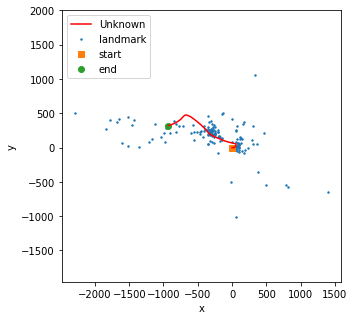

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

In [33]:
slam.visualize_trajectory_2d(show_ori=False)

In [ ]:
up

In [43]:
slam.imu_pose[1]

array([[ 9.99998695e-01,  1.14909841e-03, -1.13532206e-03,
         5.21798229e-02],
       [-1.14865060e-03,  9.99999262e-01,  3.95012267e-04,
         9.13233603e-04],
       [ 1.13577513e-03, -3.93707663e-04,  9.99999278e-01,
        -2.71988387e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [ ]:
# print(); print("Landmark Covariance"); print(slam.m_covariance.shape); print(slam.m_covariance)
# print(); print("Landmark Noise"); print(slam.m_V.shape); print(slam.m_V)

In [ ]:
landmarks = slam.m_mu.reshape((slam.M, 3))
z = landmarks[:, 2]
z_place = np.where((z<70)& (z>-150))

landmarks = slam.m_mu.reshape((slam.M, 3))
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(slam.imu_pose[:,0, 3], slam.imu_pose[:, 1, 3], 'r-', label="path")
ax.scatter(landmarks[z_place, 0], landmarks[z_place, 1], s=2)

In [ ]:
1/np.nan

In [ ]:
np.sum(z)/z.size

In [ ]:
plt.scatter(landmarks[z_place, 0], landmarks[z_place, 1])